## Introduction
Project 2 will continue the work with census data from [Project 1](https://gist.github.com/kjprice/820c75bd8e5c3f2558f4576f38893dae) and the [Mini Project](https://gist.github.com/kjprice/bb3ecd63e7a2e5050c018d63c875a79b), to take a deeper look into the data. The analysis of this project will focus on the predictive classification ability.  Methods for both categorical variables as well as continuous variables will be evaluated.  

In [16]:
import numpy as np 
import pandas as pd
import seaborn as sns

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats

# load in raw dataset
person_raw = pd.read_csv('../data/person-subset-2.5percent.csv')

# clean data (as performed in Project 1)
# will provide us with a new dataset "df"
# ...and a list of "important_features"
execfile('../python/clean_data_person.py')

The `important_features` discovered from the first project will continue to be utilized in this project.

In [17]:
df[important_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60357 entries, 0 to 60356
Data columns (total 15 columns):
PINCP        60357 non-null float64
POVPIP       57892 non-null float64
JWMNP        32486 non-null float64
AGEP         60357 non-null int64
PWGTP        60357 non-null int64
PAP          60357 non-null float64
CIT          60357 non-null object
ENG          60357 non-null object
COW          60357 non-null object
PUMA         60357 non-null category
SEX          60357 non-null object
MIL          60357 non-null object
SCHL         60357 non-null float64
MAR          60357 non-null object
affluency    60312 non-null category
dtypes: category(2), float64(5), int64(2), object(6)
memory usage: 6.6+ MB


### Data Descriptions

The included attributes with descriptions:
  * AGEP:  Age of person (continuous 0-95)
  * CIT:  Citizenship status (categorical - numerical key)
  * CIT_CAT:  Citizenship status (categorical - string)
  * COW:  Class of worker (categorical - string)
  * ENG:  Ability to speak English (categorical scale of 1-4 and native speakers)
  * JWMNP:  Travel time to work (continuous - minutes of commute to work)
  * JWTR:  Means of transportation to work (categorical - 12 modes of transportation)
  * MAR:  Marital status (categorical - 5 categories: married, divorced, separated, single, widow)
  * PAP:  Public assistance income past 12 months (continuous variable of dollars of assistance received)
  * PINCP:  Total person's income (continuous of total income)
  * POVPIP:  Income-to-poverty ratio recode (continuous with a cap at 501)
  * SCHL:  Educational attainment (continuous - years of completed education)
  * SEX:  Sex (gender of female or male)

### Classification variable

A new variable has been created to categorize wealth.   The new variable called `affluency` which can be one of two levels - "general" or "rich" (greater than $100,000 income):

In [18]:
def create_affluency():
    global lr
    global important_features

    lr = df[important_features].copy(deep=True)
    lr['affluency'] = pd.cut(df.PINCP, [-1, 99999.99, 1e12], labels=('general', 'rich'))
create_affluency()

### Cleanup

As performed in the previous project, unneccesaary variables are removed from the dataset: 
 - `POVPIP`
 - `PINCP`
 - `PUMA`
 - `MIL`
 - `MAR`
 - `SCHL`

The "Travel Time" (`JWMNP`) attributed is grouped into appropriate intervals (previously a continuous variable):
 - `na`
 - `short`
 - `half hour`
 - `hour`
 - `long`
 
Then, from the variables `affluency` and `SEX`, boolean variables of `wealthy` and `is_male` are created respectively.

Finally, one-hot-encoding is performed on other categorical variables `travel_time`, `CIT`, `ENG`, `COW`.

All of this gives the following:

In [19]:
execfile('../python/clean_data_classification.py')
lr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60357 entries, 0 to 60356
Data columns (total 49 columns):
PINCP                                              60357 non-null float64
AGEP                                               60357 non-null int64
PWGTP                                              60357 non-null int64
PAP                                                60357 non-null float64
wealthy                                            60357 non-null bool
is_male                                            60357 non-null int32
Travel_Time__na                                    60357 non-null uint8
Travel_Time__short                                 60357 non-null uint8
Travel_Time__half hour                             60357 non-null uint8
Travel_Time__hour                                  60357 non-null uint8
Travel_Time__long                                  60357 non-null uint8
Citizen__Born Abroad)                              60357 non-null uint8
Citizen__Naturalized    

### PCA

A principal components analysis is also performed with five components on a scaled-version of our dataset. Although the PCA is not officially part of the classification analysis, the data may be useful for comparative reference. 

In [20]:
df[pca_features].head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4
0,1.884722,1.800257,0.924182,-0.699640,-0.178168
1,0.337951,-1.349852,0.459929,-0.865061,0.821997
2,-1.203093,-0.315044,-0.527054,-0.989048,1.147468
3,-0.173147,-1.279213,-0.209784,-0.614139,-0.449463
4,1.361579,1.421788,-0.016835,-1.109766,0.966595


## Evaluation metric

Ultimately, we are hoping to classify individuals as either _wealthy_ (income > \$100,000) or _general_ (income < \$100,000). Being so, we want our model to be as accurate as possible and will consider accuracy to be the most important metric.

Our dataset is highly unbalanced with only 7% of the population being classified as "wealthy". Because of this unbalance, we want to keep an eye on the F-measure. A model may choose to take the easy way out, obtaining nearly 92% accuracy by simply classifying all individuals as "general". The F-measure will be a secondary metric to accuracy.

For regression, we will use r^2 as the metric. This will give us a metric which is on the same scale as accuracy.

## Dividing Data

To help ensure that overfitting is mitigated, we will use a 10-fold cross validation technique to split our dataset. Because our dataset is so unbalanced, we will use a stratified k-fold cross validator.

Additionally, we will scale our dataset so that various classification techniques can be used.

In [21]:
def get_X_y(regression=False):
   global lr2
   lr2 = lr.copy(deep=True)
   y = list(lr2.wealthy.values)
   if regression:
       y = list(lr2.PINCP.values)
   del lr2['wealthy']
   del lr2['PINCP']
   X = lr2.values
   
   ### Standardize X values
   scl_obj = MinMaxScaler()
   scl_obj.fit(X)
   X = scl_obj.transform(X)
 
   return (X,y)

## Creating models

We will try to classify the individuals of our dataset as being wealthy (or not) using several techniques including Naive Bayes, Decision Trees, and KNN. Then we will try to regress our dataset to predict the actual income of the individual using linear regression.

### Helper functions

We will create two functions to help us with cognitive overload by cleaning our code down to the essential pieces:

In [22]:
# variables to be used later
methodSpeeds = []
methodSpeedNames = []
_results = []
names = []

def print_accuracy(title, results):
    accuracy = round(results.mean()*100, 2)
    std = round(results.std(), 6)
    print('%s%% accuracy (%s std) - %s' % (accuracy, std, title))

def fit_and_test(title, model, show_individual_accuracies=False, print_confusion=False, regression=False, scoring='accuracy'):
    startTime = datetime.now()

    X, y = get_X_y(regression)
    
    cv_results = model_selection.cross_val_score(model, X, y, cv=10, scoring=scoring)
    
    _results.append(cv_results)
    names.append(title)
    
    print_accuracy(title, cv_results)

    methodSpeedNames.append(model.__class__.__name__)
    timePassed = datetime.now() - startTime
    methodSpeeds.append(timePassed.total_seconds())

### Decision Trees

In [23]:
dt_clf = DecisionTreeClassifier(max_features=None, class_weight='balanced')
fit_and_test('decision tree (no max feature)', dt_clf)
dt_clf = DecisionTreeClassifier(max_features=4, class_weight='balanced')
fit_and_test('decision tree (max_features=4)', dt_clf)
dt_clf = RandomForestClassifier(max_features=None, class_weight='balanced')
fit_and_test('Random Forest', dt_clf)

89.68% accuracy (0.002525 std) - decision tree (no max feature)
89.76% accuracy (0.003107 std) - decision tree (max_features=4)
92.47% accuracy (0.001299 std) - Random Forest


We can get nearly **90%** accuracy using a decision tree. We are not seeing much difference when changing the `max_features` parameter except a slight speed boost when limiting the featuers. Using a random forest, however, seems to give us a bit of a boost in accuracy of about **92%** total.

### Multinomial Bayes

In [24]:
mb_clf = MultinomialNB(alpha=100)
fit_and_test('bayes multinomial (alpha=100)', mb_clf, show_individual_accuracies=False)
mb_clf = MultinomialNB(alpha=1)
fit_and_test('bayes multinomial (alpha=1)', mb_clf, show_individual_accuracies=False)
mb_clf = MultinomialNB(alpha=.001)
fit_and_test('bayes multinomial (alpha=.001)', mb_clf, show_individual_accuracies=False)

92.74% accuracy (0.001426 std) - bayes multinomial (alpha=100)
92.82% accuracy (0.001239 std) - bayes multinomial (alpha=1)
92.82% accuracy (0.001171 std) - bayes multinomial (alpha=.001)


With multinomial Bayes, we are getting an accuracy around **93%** consistently. A chance in the `alpha` parameter does not seem to produce a significant change in accuracy.

### Bernoulli Bayes

In [25]:
mb_clf = BernoulliNB(alpha=100)
title_with_params = 'bayes bernoulli alpha=100, binarize=None'
fit_and_test(title_with_params, mb_clf, show_individual_accuracies=False)
mb_clf = BernoulliNB(alpha=.1)
title_with_params = 'bayes bernoulli alpha=0.1, binarize=None'
fit_and_test(title_with_params, mb_clf, show_individual_accuracies=False)
mb_clf = BernoulliNB(alpha=.1, binarize=1)

print('')

title_with_params = 'bayes bernoulli alpha=0.1, binarize=1'
fit_and_test(title_with_params, mb_clf, show_individual_accuracies=False)
mb_clf = BernoulliNB(alpha=100, binarize=1)
title_with_params = 'bayes bernoulli alpha=100, binarize=1'
fit_and_test(title_with_params, mb_clf, show_individual_accuracies=False)


92.03% accuracy (0.002165 std) - bayes bernoulli alpha=100, binarize=None
91.35% accuracy (0.002516 std) - bayes bernoulli alpha=0.1, binarize=None

92.68% accuracy (6e-06 std) - bayes bernoulli alpha=0.1, binarize=1
92.68% accuracy (6e-06 std) - bayes bernoulli alpha=100, binarize=1


Bernoulli Bayes gives about **92%** accuracy with a slight gain for setting the property `binarize=1`.

### Gaussian Bayes

In [26]:
mb_clf = GaussianNB()
fit_and_test('bayes gaussian', mb_clf, show_individual_accuracies=False)

42.82% accuracy (0.005449 std) - bayes gaussian


The Gaussian Bayes performs terribly. Many of our features are nominal or binomial, so it makes sense that this would not perform well. Even with the assumption of normal distribution unmet, the fact that this performs worse than a random guess might do (less than 50%) is pretty startling.

### Gradient Descent

In [27]:
regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const, class_weight='balanced',
       fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
       loss='hinge', n_iter=iterations, n_jobs=-1, penalty='l2')

fit_and_test('gradient descent', svm_sgd, show_individual_accuracies=False)

72.01% accuracy (0.008869 std) - gradient descent


Stochastic gradient descent does not seem to provide an accurate model for our particular dataset.

### Decision Tree Regressor

In [28]:
dt_reg = DecisionTreeRegressor(max_depth=5)
fit_and_test("Decision Tree Regressor", dt_reg, regression=True, scoring='r2')

23.58% accuracy (0.019461 std) - Decision Tree Regressor


Our metric is no longer _accuracy_, because this is a regression function, but instead we are using _r^2_. The decision tree regressor gives us an r^2 of around **23%**.

## Analyze Results


First, we can take a look at comparing our selected metrics _accuracy_ (for classification) and _r^2_ (for regression).

### Compare Metrics

Here we compare our top-performing models using blox plots of the accuracies for the 10fold cross validation. The Bayes multinomial model, with alpha set to .001 seems to provide the highest accuracy with moderate variance. If variance was an issue, then we would want to use Bernoulli Bayes.

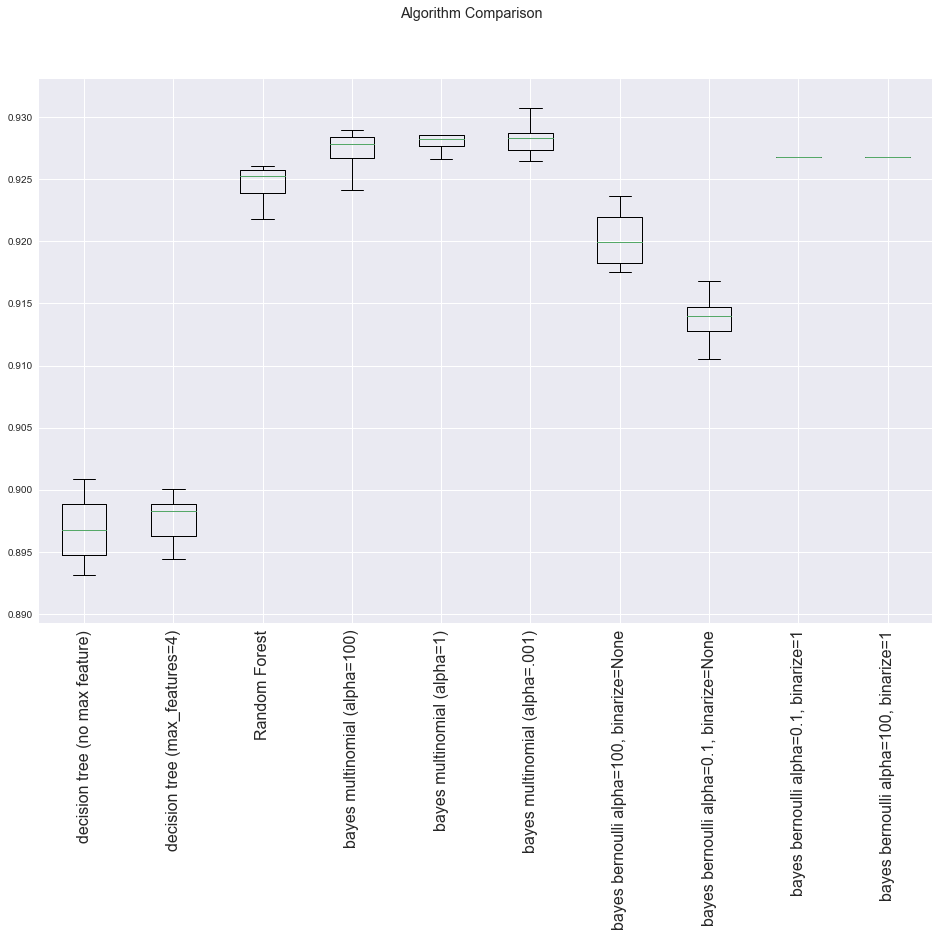

In [29]:
###Comparison of Algorithms
x_results = pd.Series(_results)
x_names = pd.Series(names)
def showAlgorithmMetricPlots(items_index):
    fig = plt.figure(figsize=(16,10))
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(x_results[items_index])
    ax.set_xticklabels(x_names[items_index], rotation=90, fontsize=16)
    plt.show()

showAlgorithmMetricPlots(x_results.map(np.mean) > .8)


### Statistically compare models

We can clearly see that there are different accuracies between the models, but are the differences statistically significant? First we can take a look at the F-Statistic (and p-value) for comparing the first six models. This of course requires the assumptions of normality between the accuracy samples as well equal variance. Normality can be assumed, but we will continue with skepticism in regards to equal variance.

In [30]:
F, p = stats.f_oneway(_results[0], _results[1], _results[2], _results[3], _results[4], _results[5])
print ('F statistic %s and p-value %s' %(F, p))

F statistic 572.925495672 and p-value 1.80272381786e-45


Clearly, there is overwhelming evidence to suggest that at least one of the models has a different mean. Let us dive deeper and look at the t-test statistic of the two highest-performing bayes models where one has alpha of 1 and the other of .001.

In [31]:
t, p = stats.ttest_ind(_results[4], _results[5])
print ('T statistic %s and p-value %s' %(t, p))

T statistic -0.0874468434361 and p-value 0.931281834641


With such a large p-value, we are unable to reject the assumption that the two distributions have the same mean.

### Compare Time to complete

We can also look at how long the functions take to complete. Here we compare time (in seconds) for each models' training and testing to complete.

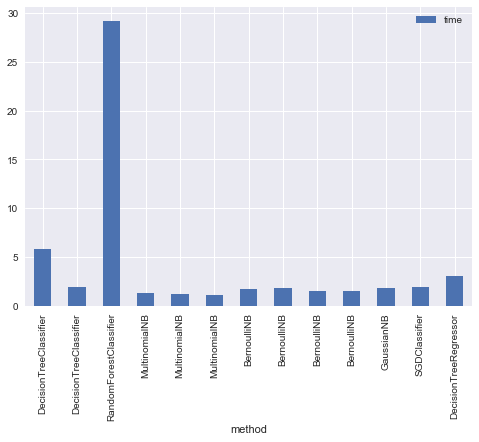

In [32]:
def showSpeedPlot():
   speeds = pd.DataFrame({'method': methodSpeedNames, 'time': methodSpeeds})
   speeds.plot.bar(x='method', y='time')
   plt.show()
showSpeedPlot()

The Multinomial Bayes model is clearly the fastest model. Based on our analysis, the Multinomial Bayes models gives us both the best accuracy and is the fastest compared to all other classification techniques we have explored. However, we do not have convincing evidence that a change in an alpha can give us better accuracy on our Multinomial Bayes model.

### Compare F1 score

Because our dataset is so unbalanced, it would be wise to check the F1 score to take a look at precision and recall. Let's use the Multinomial Bayes model to check the statistic:

In [33]:
X, y = get_X_y()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.2, random_state=42)

mb_clf = MultinomialNB(alpha=1)
mb_clf.fit(X_train, y_train)

y_hat = mb_clf.predict(X_test)

acc = mt.accuracy_score(y_test, y_hat)
print(mt.confusion_matrix(y_test, y_hat))
print('F1 score %s' % mt.f1_score(y_test, y_hat))

[[10997   182]
 [  679   214]]
F1 score 0.33204034135


The confusion matrix and the F1 score both show what we were hoping to avoid. There were three times as many people incorrectly classifed as "general" (679) as there were correctly classified as "wealthy" (214). A small F1 score furth asserts our concerns. Indeed we would hope for a larger F1 score, but with our dataset so unbalanced, this might be the best we can achieve. We should proceed with caution.

## Most important features

With Multinomial Bayes being our strongest model for accuracy, let's consider the coefficients which are outputted from fitting the model.

In [34]:
X, y = get_X_y()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.2)

mb_clf = MultinomialNB(alpha=1)
mb_clf.fit(X_train, y_train)

chosen_coeficients = pd.Series(mb_clf.coef_[0])
chosen_coeficients.index = lr2.columns
chosen_coeficients = chosen_coeficients.sort_values()

# All coefficients seem to be negative, let's offset them to show some positive weights
chosen_coeficients + 7

Worker_Class__Unemployeed                         -3.282635
English__Not at all                               -1.896341
PAP                                               -1.827904
Education_Attained__na                            -1.490876
Worker_Class__Family Business - no pay            -1.085410
Education_Attained__no_high_school                -0.643578
Citizen__US Territory Born                        -0.574585
Miliary_Service__Serving Active Duty              -0.238113
English__Not well                                 -0.147141
Marital_status__Separated                          0.243725
Citizen__Born Abroad)                              0.354951
Education_Attained__some_high_school               0.406244
English__Well                                      1.228224
Miliary_Service__Reserves                          1.260660
Marital_status__Widowed                            1.496488
Worker_Class__State Government                     1.504857
Citizen__Non-Citizen                    

Clearly never being in the military seems to be an important feature. Additional research might be warranted into why this feature is so important.

Other features seem less surprising: Being married, born in US, and only speaking English are the next most important positive features. The most important negative features are: being unemployed, receiving public assistance in the last 12 months (`PAP`), and not speaking English.

## Deployment

We are achieving about 93% accuracy for our model. We may want to work on getting the accuracy up higher as you could, theoretically, get about 92% by naively classifying all people as "general" wealth.

For true classification, we would want to see this model in production. To deploy, we may want to use a low-level, compiled langauge such as Java to be in charge of handling the actual clssification of real data.

## Exceptional Work

We have used two regression models which were not discussed in class.